# **Data Collection**
---

## Objectives

* Answer Business Requirement 1:
  * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* inputs/cherry_leaves_dataset/cherry-leaves/test

## Outputs

* Image shape embeddings pickle file
* Mean and variability of images per label plot
* Plot to distinguish contrast between healthy and powdery mildew-infected cherry leaves.
* Generate code to answer business requirement 1 and can be used to build a gallery of images on the Streamlit dashboard

## Additional Comments

* No comments
---

## **Set Data Directory**
---
### Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set working directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves-p5/jupyter_notebooks'

In [4]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves-p5')
print('You set a new current directory')

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves-p5'

### Set input directories

In [6]:
my_data_dir = current_dir + '/' + 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

# Checks to see if a specified version already exists in the outputs folder in the workspace
if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available. Create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available. Create a new version.


### Set the label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## **Data Visualisation of Image Data**
---

### Image Shape

Calculate the mean dimensions of the images in the train set

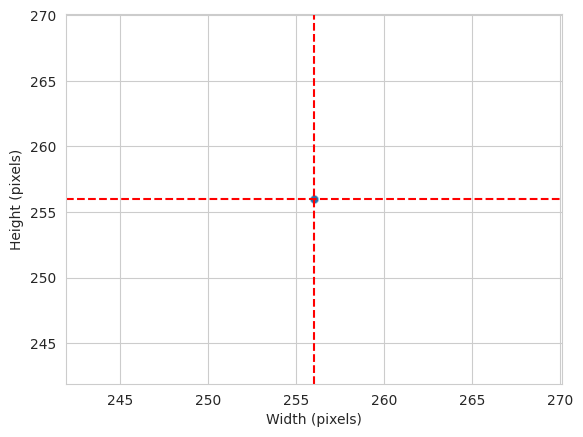

Width average: 256 
Height average: 256


In [9]:
# Arrays that store the height and widths of each image
dim1, dim2 = [], []

# Loop through each label (healthy, powdery_mildew)
for label in labels:
    # Loop through each img in both categories
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        
        # Gather the dimensions of each img
        d1, d2, colors = img.shape

        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")

# Scatter plot showing width against height for all imgs
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)

# Labelling x and y axes
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Calculate the average dimensions
dim1_mean = int(np.array(dim1).mean())  # average height
dim2_mean = int(np.array(dim2).mean())  # average width

# Styling to show the cross-section where average dimensions meet
axes.axvline(x=dim1_mean, color='r', linestyle='--')  # vertical line for height
axes.axhline(y=dim2_mean, color='r', linestyle='--')  # horizontal line for width

plt.show()

print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

The image size used for training the model will be the average/ mean size of all images in the train set

In [10]:
img_shape = (dim1_mean, dim2_mean, 3)
img_shape

(256, 256, 3)

Save the image shape embeddings

In [11]:
joblib.dump(value=img_shape,
            filename=f'{file_path}/img_shape.pkl')

['outputs/v1/img_shape.pkl']

---
### Average and Variability of Images per Label

Function to load images in an array (TensorFlow)

In [12]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X_list = [] # Stores the image arrays
    y_list = [] # Stores the respective labels

    # Get the list of labels (healthy, powdery_mildew)
    labels = os.listdir(my_data_dir)

    # Iterate through each label
    for label in labels:
        label_path = my_data_dir + '/' + label
        # Validating that the label_path is a directory
        if not os.path.isdir(label_path):
            continue

        # Get all image files in the label's folder
        image_files = os.listdir(label_path)
        for i, image_filename in enumerate(image_files):
            # Iterates over the indices of the imgs
            if i >= n_images_per_label:
                break # Ensures only a specific num of imgs are taken from each label

            image_path = label_path + '/' + image_filename

            # Load and resize image
            img = image.load_img(image_path, target_size=new_size)

            # Convert to array and normalize
            img_array = image.img_to_array(img)
            if img_array.max() > 1:
                img_array = img_array / 255.0

            X_list.append(img_array)
            y_list.append(label)

    # Convert lists to numpy arrays
    X = np.array(X_list)
    y = np.array(y_list)

    return X, y

2025-04-11 13:46:35.513552: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 13:46:36.510771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the image shapes and labels as an array

In [13]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=img_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot and save the **Mean** and **Variability** of images per label

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    # Loop through both labels in the dataset (healthy, powdery_mildew)
    for label_to_display in np.unique(y):
        sns.set_style("white")  # Set styling for the plots

        # Reshapes y into a 3D array
        y = y.reshape(-1, 1, 1)

        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)

        # Selects images with the current label
        arr = X[boolean_mask]

        # Calculates the average and standard deviation image for the label
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)

        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")

        # Creates plots of average and variability images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for Label: {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')  # Show average image

        axes[1].set_title(f"Variability Image for Label: {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')  # Show standard deviation image

        # If requested, the plot is saved as an image file
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()  # Otherwise, just display the plot
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


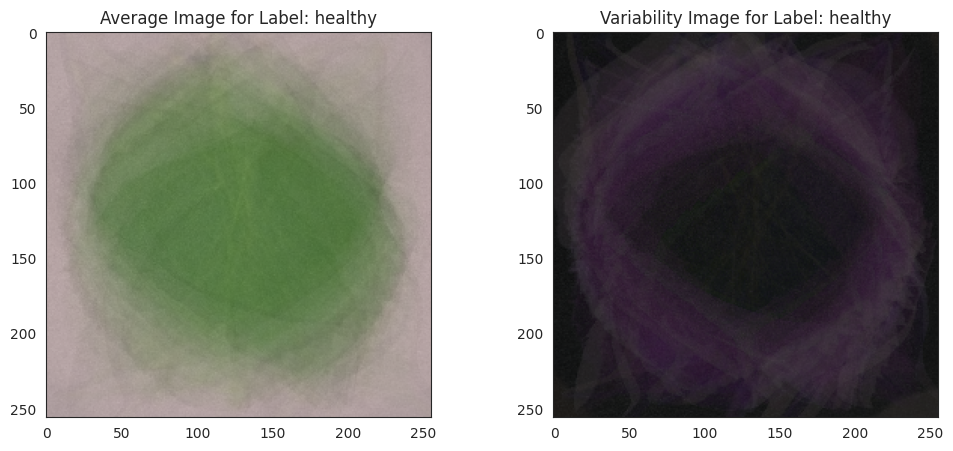

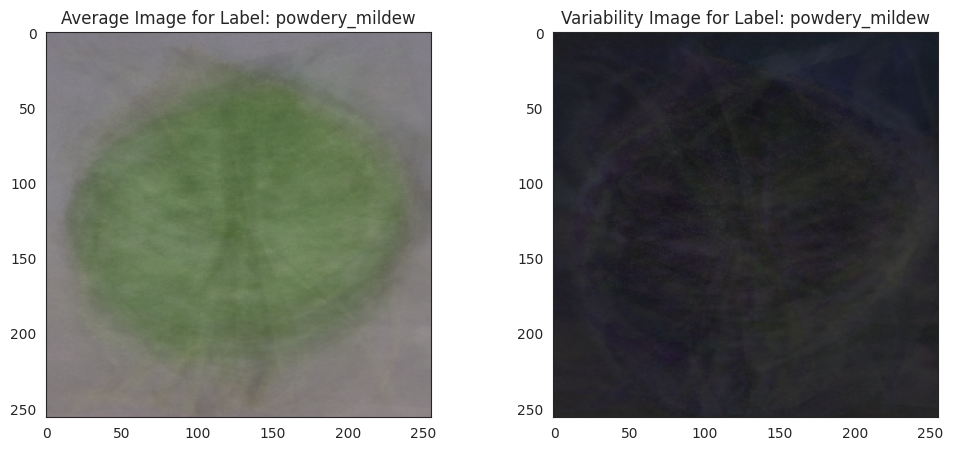

In [15]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5), save_image=True)

---
### Difference between Healthy and Powdery Mildew Infected Cherry Leaves

In [ ]:
def subset_image_label(X, y, label_to_display):
    # Reshape y to a 3D array
    y = y.reshape(-1, 1, 1)

    # Create a boolean mask
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)

    # Use the boolean mask to select images from X that match the appropriate label
    df = X[boolean_mask]

    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):

    sns.set_style("white")

    # Ensures that both labels (healthy, powdery_mildew) exist in the dataset
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} is not in {np.unique(y)}")
        return

    # Collate all images from label_1, calculate average image of specified label
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # Collate all images from label_2, calculate average image of specified label
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # Calculate the difference between those two averages
    difference_mean = label1_avg - label2_avg

    # Plot the average images and their difference
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average: {label_1}')

    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average: {label_2}')

    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference b/w Avg: {label_1} & {label_2}')

    # If requested, save the plot as an image file, otherwise it is simply displayed to the user
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


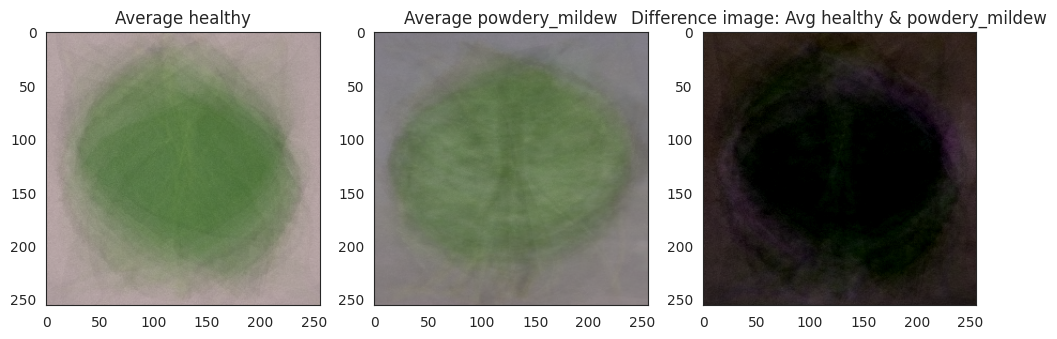

In [18]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12,10),
                                        save_image=True)

---
### Image Gallery

In [ ]:
import itertools
import random

sns.set_style("white")  # Set styling for the plots

def image_gallery(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):

    labels = os.listdir(dir_path)  # Get both labels (healthy, powedery_mildew) in the directory

    # Ensure the specified label exists in this directory
    if label_to_display in labels:
        images_list = os.listdir(dir_path + '/' + label_to_display)  # Collate all images associated to label

        # Validates the gallery space (nrows * ncols) is enough for the number of images you want to display
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)  # Randomly sample images if there are more images than spaces
        else:
            print(
                f"Decrease nrows or ncols to create your gallery. \n"
                f"There are {len(images_list)} images in the subset. "
                f"You requested a gallery with {nrows * ncols} spaces")
            return  # Exit the function if gallery size is larger than available images

        # Generate a list of (row, col) indices for placing images in the gallery
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # Create a figure and axes to display the gallery
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)